<a href="https://colab.research.google.com/github/jumacaq/Robot_Trading_BTC-USD/blob/main/Robot_Trading_BTC_USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ROBOT TRADING BTC-USD**

*autor: Juan Campos Quintana*

El proyecto consiste en crear un **Robot Trading en Python** que tome decisiones de compra-venta de la principal criptomoneda del mercado, basadas en datos en tiempo real usando técnicas para extracción de datos desde una API, Web scraping, tratamiento y manipulación de datos con librerías Numpy y Pandas, y creación de gráficos con Matplotlib.

El proyecto consta de 6 etapas que se muestran a continuación.

##1- Configuración de ambiente

In [ ]:
#Versión de python
!python -V

Python 3.11.11


In [ ]:
# Importar librerías de manipulación de datos
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas del DataFrame
pd.set_option('display.expand_frame_repr', False)  # Evitar que el DataFrame se divida en varias líneas si tiene muchas columnas

# Importar librerías para manejo de tiempo y fecha
import time
from datetime import datetime, timedelta

# Importar librerías de scraping
import requests
from bs4 import BeautifulSoup

# Importar librerías de visualización
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (5, 5))  # Establecer el tamaño predeterminado de las figuras a 5x5 pulgadas

# Importar librerías específicas de entorno Jupyter
from IPython.display import clear_output

# Importar librería para obtención de datos financieros
import yfinance as yf

In [ ]:
#Muestra versiones de las bibliotecas
# Verificar la versión de Python
!python --version

# Verificar la versión de pandas
!pip show pandas | grep Version

# Verificar la versión de numpy
!pip show numpy | grep Version

# Verificar la versión de matplotlib
!pip show matplotlib | grep Version

Python 3.11.11
Version: 2.2.2
Version: 1.26.4
Version 3.1, 31 March 2009
                       Version 3, 29 June 2007
  5. Conveying Modified Source Versions.
  14. Revised Versions of this License.
Version: 3.10.0


In [ ]:
#Definimos las variables globales
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision, color

##2- Obtención de datos

###2.1- Precio histórico del Bitcoin

Lo obtendremos extrayendo el precio histórico del Bitcoin desde la API de Yahoo Finance utilizando la librería `yfinance` de Python, esta variable la guardaremos en la función `importar_base_bitcoin()`

In [ ]:
#Creamos la función importar_base_bitcoin() que retornará el DataFrame con el precio histórico del Bitcoin
def importar_base_bitcoin():
  global df_bitcoin
  end_date = datetime.now() #Obtengo la fecha actual con la librería datetime y método datetime.now()
  start_date = end_date - timedelta(days=14) #Obtengo la fecha de inicio del análisis restando 14 dias a la fecha actual con método timedelta
  df_bitcoin = yf.download(      #Descargo los datos desde la API de Yahoo Finance
      tickers="BTC-USD", # se determina el activo
      # configuración de fecha de inicio y termino
      start=start_date.strftime('%Y-%m-%d'),
      end=end_date.strftime('%Y-%m-%d'),
      interval="15m" # periódo de tiempo donde se evalúa el comportamiento del precio
      )
  if df_bitcoin.empty:  #Si la informacion que descargo esta vacia, entonces me lanza el error
    raise ValueError("No se encontraron datos para el intervalo especificado.")
  #Aplanar el MultiIndex de las columnas
  df_bitcoin.columns = [col[0] for col in df_bitcoin.columns] # se mostrará solo el primer string de los encabezados
  return df_bitcoin

In [ ]:
importar_base_bitcoin() #Lanzamos la funcion para observar los datos


[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Datetime,,,,,
2025-01-16 00:00:00,100375.664062,100739.640625,100355.359375,100500.351562,518549504
2025-01-16 00:15:00,100372.101562,100476.617188,100165.273438,100327.031250,178716672
2025-01-16 00:30:00,99683.851562,100372.796875,99683.851562,100372.796875,204820480
2025-01-16 00:45:00,99857.671875,99857.671875,99708.906250,99750.335938,384765952
2025-01-16 01:00:00,99941.945312,100054.210938,99864.015625,99890.820312,158392320
...,...,...,...,...,...
2025-01-29 22:45:00,103569.093750,103638.429688,103495.460938,103495.460938,0
2025-01-29 23:00:00,104026.156250,104026.156250,103468.351562,103468.351562,122466304
2025-01-29 23:15:00,104147.671875,104274.656250,104035.476562,104075.125000,193511424


###2.2- Indicadores de tendencia

Utilizaremos la librería `BeautifulSoup` para hacer Web Scraping de la página `https://coinmarketcap.com/` para extraer el precio actual del Bitcoin BTC en dólares USD y la variación de su precio en la última hora, ambas variables serán guardadas en la función `extraer_tendencias()`


In [ ]:
def extraer_tendencias():
    global precio_actual, tendencia, color

    # Colocamos el encabezados y la petición
    headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36"}
    url = "https://coinmarketcap.com/es/currencies/bitcoin/"
    try:
        #Usamos el try y except para en caso de ser bloqueados para captar el error
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # En caso de que el error sea de HTTP

        # Creamos un alias a la librería BeautifulSoup, luego extraemos información con su método find()
        s = BeautifulSoup(response.content, "html.parser")

        #Extraemos el precio actual del Bitcoin desde la etiqueta HTML ´span'
        label_precio = s.find('span', {"data-test":"text-cdp-price-display"})#extrae el precio
        if label_precio:
            precio_actual = float(label_precio.getText().replace("$", "").replace(",", "")) #Eliminamos el signo # y las comas del texto del precio
        else:
            precio_actual = None #Si el precio esta vacio entonces nos imprime que no pudo obtener el precio
            print("No se pudo obtener el precio de la pagina.")

        #Extraemos la tendencia del precio de Bitcoin desde la etiqueta HTML 'p'
        label_variacion = s.find('p', {'color': True, 'data-change': True})
        if label_variacion:
            color = label_variacion['color']
            if color == 'green':
                tendencia = "alta"
            elif color == 'red':
                tendencia = "baja"
            else:
                tendencia = None #"Esperar"
        return precio_actual, tendencia
    except requests.exceptions.RequestException as e:
        print(f"Error al hacer la solicitud: {e}") #Mensaje de error en caso de que salte una excepción
        return None, None

# Se prueba la función
extraer_tendencias()
print('Precio Bitcoin: ', precio_actual)
print('Tendencia:', tendencia)


Precio Bitcoin:  105258.32
Tendencia: alta


##3- Limpieza de datos

Creamos una copia de la base de datos `df_bitcoin` para realizar la limpieza de datos en `df_bitcoin_limpio` sin modificar la base de datos original. Luego removemos los duplicados, valores nulos y valores atipicos con la función `limpieza_datos()`.


### 3.1- Exploración inicial de la información


In [ ]:
df_bitcoin.head() #Traemos la base de datos para observarla y entenderla

,Close,High,Low,Open,Volume
Datetime,,,,,
2025-01-16 00:00:00,100375.664062,100739.640625,100355.359375,100500.351562,518549504
2025-01-16 00:15:00,100372.101562,100476.617188,100165.273438,100327.031250,178716672
2025-01-16 00:30:00,99683.851562,100372.796875,99683.851562,100372.796875,204820480
2025-01-16 00:45:00,99857.671875,99857.671875,99708.906250,99750.335938,384765952
2025-01-16 01:00:00,99941.945312,100054.210938,99864.015625,99890.820312,158392320


Es importante entender el contenido del DataFrame:

**Datetime**: Es el índice del dataframe, y contiene la fecha y hora del intervalo seleccionado, no puede estar duplicado.

**Open**: Contiene el precio del Bitcoin al inicio del intervalo.

**High**: Contiene el precio más alto del Bitcoin durante el intervalo.

**Low**: Contiene el precio más bajo del Bitcoin durante el intervalo.

**Close**: Contiene el precio del Bitcoin al final del intervalo.

**Volume**: Contiene el total de transacciones hechas durante el intervalo.

Para la limpieza utilizaremos los atributos `Datetime`, `Close`  y `Volume`

In [ ]:
df_bitcoin.info() #Nos indica el numero de filas, el numero de columnas, y el tipo de dato

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1344 entries, 2025-01-16 00:00:00 to 2025-01-29 23:45:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1344 non-null   float64
 1   High    1344 non-null   float64
 2   Low     1344 non-null   float64
 3   Open    1344 non-null   float64
 4   Volume  1344 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 63.0 KB


In [ ]:
df_bitcoin.describe() #Nos arroja estadisticas descriptivas de la columnas numericas

,Close,High,Low,Open,Volume
count,1344.000000,1344.000000,1344.000000,1344.000000,1.344000e+03
mean,103358.576608,103521.485392,103184.825376,103350.480515,2.338588e+08
std,2042.125839,2044.145005,2044.722103,2046.618328,5.342568e+08
min,97605.289062,98104.835938,97421.203125,97421.203125,0.000000e+00
25%,102002.015625,102195.603516,101850.224609,102007.822266,0.000000e+00
50%,103776.000000,103975.703125,103525.128906,103787.339844,2.512486e+07
75%,104875.410156,104983.886719,104743.941406,104877.074219,2.322360e+08
max,108837.968750,109110.390625,108120.093750,108899.929688,6.540714e+09


### 3.2- Diagrama de caja del precio de cierre sin tratar

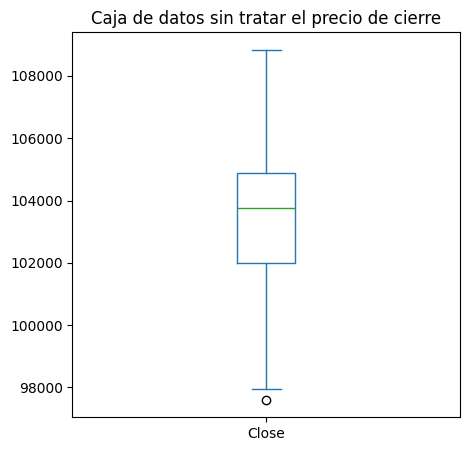

In [ ]:
#Identificamos los valores atípicos en la columna 'Close', se usa un diagrama de caja
df_bitcoin['Close'].plot.box()
plt.title('Caja de datos sin tratar el precio de cierre')
plt.show()

### 3.3- Funcion de limpieza de datos

In [ ]:
# Creamos una copia de df_bitcoin para limpiar los datos
df_bitcoin_limpio = df_bitcoin.copy()

In [ ]:
def limpieza_datos():
  global df_bitcoin, df_bitcoin_limpio, media_bitcoin
  num_datos_iniciales = df_bitcoin_limpio.shape[0]
  #Eliminamos las filas duplicadas pero manteniendo siempre la primer  fila
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]#Este código retornará los elementos que no estan duplicados
  #print(f'Duplicate dropped: {num_datos_iniciales-df_bitcoin_limpio.shape[0]}')
  #Llena los valores nulos en la columna 'Close' con el ultimo valor valido
  df_bitcoin_limpio['Close'] = df_bitcoin_limpio['Close'].ffill()
  #Revisamos que la filas en la columna 'Volume' sean mayor a 0, de otra forma se borra.
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0] #Eliminamos los valores = 0 en la columna 'Volume'
  #Calculamos los cuartiles para eliminar los valores atipicos fuera del rango.
  Q1 = df_bitcoin_limpio['Close'].quantile(.25) #quartil 1 = 25% de los datos
  Q3 = df_bitcoin_limpio['Close'].quantile(.75) #quartil 3 = 75% de los datos
  IQR = Q3 - Q1 #Rango entre los cuartiles
  selection = (df_bitcoin_limpio['Close'] >= Q1 - 1.5 * IQR) & (df_bitcoin_limpio['Close'] <= Q3 + 1.5 * IQR) #Creamos una ecuacion de filtro para detectar valores dentro del rango aceptable
  df_bitcoin_limpio = df_bitcoin_limpio[selection] #Usamos la ecuacion en los datos limpios para filtrar
  media_bitcoin = df_bitcoin_limpio['Close'].mean().round(2) #Calculamos la media y lo redondeamos a 2 decimales
  num_datos_finales = df_bitcoin_limpio.shape[0] #Con esto me doy cuenta cuantas filas se elimino en la limpieza

  return df_bitcoin_limpio, media_bitcoin


In [ ]:
limpieza_datos() #Lanzamos la funcion e imprimimos los resultados
print('Número de filas inicial:', df_bitcoin.shape[0])
print('Número de filas despues de limpieza:', df_bitcoin_limpio.shape[0])
print('Número de filas eliminadas:', df_bitcoin.shape[0] - df_bitcoin_limpio.shape[0])
print('Price average:', media_bitcoin)

Número de filas inicial: 1344
Número de filas despues de limpieza: 783
Número de filas eliminadas: 561
Price average: 103027.78


Text(0.5, 1.0, 'Diagrama de caja con datos limpios con el precio de cierre')

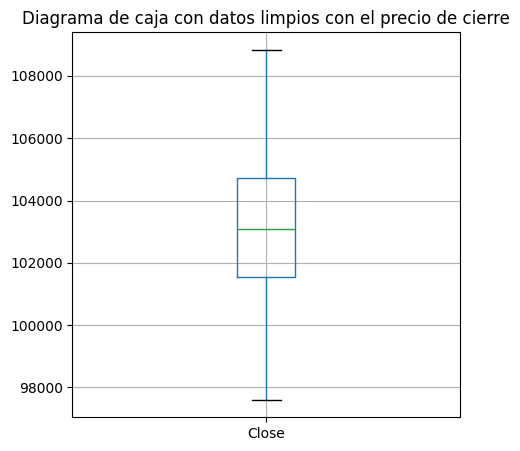

In [ ]:
#Creamos otro gráfico de caja, esta vez sin valores atípicos
df_bitcoin_limpio.boxplot(['Close'])
plt.title('Diagrama de caja con datos limpios con el precio de cierre')

In [ ]:
df_bitcoin_limpio.info()#Lanzamos la funcion para ver los cambios al limpiar la base

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783 entries, 2025-01-16 00:00:00 to 2025-01-29 23:15:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   783 non-null    float64
 1   High    783 non-null    float64
 2   Low     783 non-null    float64
 3   Open    783 non-null    float64
 4   Volume  783 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 36.7 KB


### 3.4- Comparación del precio de cierre antes y despues de la limpieza

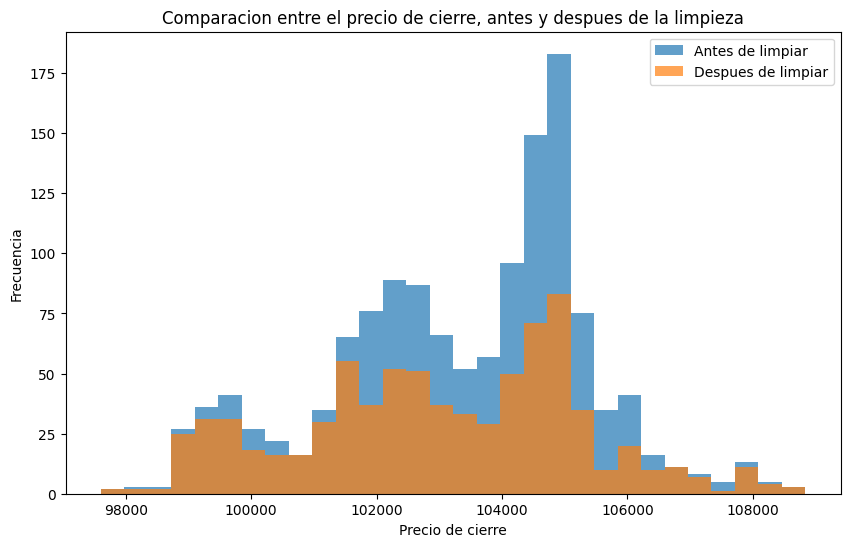

In [ ]:
#Creamos un histograma para comparar la distribución del precio de cierre antes y despues de la limpieza
plt.figure(figsize=(10,6))
plt.hist(df_bitcoin['Close'],bins=30, alpha=0.7, label='Antes de limpiar')
plt.hist(df_bitcoin_limpio['Close'],bins=30, alpha=0.7, label='Despues de limpiar')
plt.legend()
plt.title('Comparacion entre el precio de cierre, antes y despues de la limpieza')
plt.xlabel('Precio de cierre')
plt.ylabel('Frecuencia')
plt.show()

##4- Toma decisiones

Primero creamos una función `calcular_sma()` para calcular las SMA(Media movil simple) de corto y largo plazo las cuales sirven para suavizar fluctuaciones y como indicadores de toma de decisiones.

Luego crearemos una función `tomar_decisiones()` dentro de ella construiremos el algoritmo que retornará la variable `algoritmo_decision`:



### 4.1 Encontrar medias moviles

In [ ]:
def calcular_sma():
    global df_bitcoin_limpio

    # Calcular la SMA de corto plazo (por ejemplo, 10 periodos)
    df_bitcoin_limpio['SMA_short'] = df_bitcoin_limpio['Close'].rolling(window=10).mean()

    # Calcular la SMA de largo plazo (por ejemplo, 50 periodos)
    df_bitcoin_limpio['SMA_long'] = df_bitcoin_limpio['Close'].rolling(window=50).mean()
    return df_bitcoin_limpio
calcular_sma()

,Close,High,Low,Open,Volume,SMA_short,SMA_long
Datetime,,,,,,,
2025-01-16 00:00:00,100375.664062,100739.640625,100355.359375,100500.351562,518549504,NaN,NaN
2025-01-16 00:15:00,100372.101562,100476.617188,100165.273438,100327.031250,178716672,NaN,NaN
2025-01-16 00:30:00,99683.851562,100372.796875,99683.851562,100372.796875,204820480,NaN,NaN
2025-01-16 00:45:00,99857.671875,99857.671875,99708.906250,99750.335938,384765952,NaN,NaN
2025-01-16 01:00:00,99941.945312,100054.210938,99864.015625,99890.820312,158392320,NaN,NaN
...,...,...,...,...,...,...,...
2025-01-29 21:15:00,104081.156250,104317.531250,104061.593750,104197.523438,558620672,103479.921094,102424.376250
2025-01-29 21:30:00,103961.132812,104282.226562,103961.132812,104111.210938,49528832,103699.323438,102491.421094
2025-01-29 22:30:00,103511.562500,103951.390625,103511.562500,103693.117188,186896384,103899.365625,102542.064687


In [ ]:
df_bitcoin_limpio.head() #Traemos y observamos la base de datos

,Close,High,Low,Open,Volume,SMA_short,SMA_long
Datetime,,,,,,,
2025-01-16 00:00:00,100375.664062,100739.640625,100355.359375,100500.351562,518549504,NaN,NaN
2025-01-16 00:15:00,100372.101562,100476.617188,100165.273438,100327.031250,178716672,NaN,NaN
2025-01-16 00:30:00,99683.851562,100372.796875,99683.851562,100372.796875,204820480,NaN,NaN
2025-01-16 00:45:00,99857.671875,99857.671875,99708.906250,99750.335938,384765952,NaN,NaN
2025-01-16 01:00:00,99941.945312,100054.210938,99864.015625,99890.820312,158392320,NaN,NaN


In [ ]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783 entries, 2025-01-16 00:00:00 to 2025-01-29 23:15:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      783 non-null    float64
 1   High       783 non-null    float64
 2   Low        783 non-null    float64
 3   Open       783 non-null    float64
 4   Volume     783 non-null    int64  
 5   SMA_short  774 non-null    float64
 6   SMA_long   734 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 48.9 KB


### 4.2 Evaluar datos y tomar decision

In [ ]:
def tomar_decisiones():
    global df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

    # Se asegura que las columnas de las medias moviles estén en el dataframe
    if 'SMA_short' not in df_bitcoin_limpio or 'SMA_long' not in df_bitcoin_limpio:
        raise ValueError("Faltan las columnas SMA_short y SMA_long columns")#Mensaje de error si no se crearon las columnas

    # Inicia la columna 'Decision' si no existe
    if 'Decision' not in df_bitcoin_limpio:
        df_bitcoin_limpio['Decision'] = 'Esperar'

    # Se obtiene los ultimos valores de SMA_corto y SMA_largo
    latest_data = df_bitcoin_limpio.iloc[-1]
    sma_corto = latest_data['SMA_short']
    sma_largo = latest_data['SMA_long']

    # Logica de toma de decisiones basada en SMA para comprar, vender o esperar y se establece los colores de texto
    if sma_corto > sma_largo and precio_actual and tendencia == 'alta':
        algoritmo_decision = 'Comprar'
        color = '#228b22'
    elif sma_corto < sma_largo and precio_actual and tendencia == 'baja':
        algoritmo_decision = 'Vender'
        color = '#dc143c'
    else:
        algoritmo_decision = 'Esperar'
        color = '#ff8c00'
    # Se asigna la decisión al ultimo registro
    df_bitcoin_limpio.loc[df_bitcoin_limpio.index[-1], 'Decision'] = algoritmo_decision

    return algoritmo_decision

# Llamamos a las funciones
calcular_sma()
tomar_decisiones()
# Imprimimos en pantalla la decisión actual
print('Decision: ', algoritmo_decision)



Decision:  Comprar


##5- Visualización

Creamos una función `visualizacion()` dentro de ella, usando la librería `matplotlib` vamos a crear un gráfico con los siguientes pasos:

In [ ]:
def visualizacion():
  global df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision
  #Configuramos el tamaño del gráfico en una proporción de 15x8, damos color al fondo del gráfico
  plt.figure(figsize=(15,8))
  #Configuración para dar color a las líneas de precio de cierre, SMA_short y SMA_long y señal de decisión
  plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['Close'], label='Precio de Cierre', color='Gray', alpha=0.7)
  plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_short'], label='SMA_short', color='Blue',alpha=0.8)
  plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_long'], label='SMA_long', linestyle='-', color='Orange',alpha=0.8)
  ultimo_precio = df_bitcoin_limpio['Close'].iloc[-1]
  plt.scatter(df_bitcoin_limpio.index[-1], ultimo_precio, color=color, label='Señal Actual', s=200, marker='v')

  #Agregamos un título al gráfico y a los ejes x,y
  plt.title('Señal de compra/venta en base a SMA con dataset original',fontsize=15,weight = 'bold')
  plt.xlabel('Fecha')
  plt.ylabel('Precio Actual en USD')
  #Agregamos leyendas al gráfico
  plt.legend()
  #Agregamos cuadrículas al gráfico, para observar mejor las intersecciones de los ejes
  plt.grid(True,alpha=0.3)

  # Agrega un cuadro de texto a la señal de decisión
  plt.text(0.02,0.98,f'Decision actual {algoritmo_decision}',
           transform=plt.gca().transAxes,
           bbox=dict(facecolor='yellow', alpha=0.3),
           verticalalignment='top'          )
  #Ajustamos los elementos dentro del gráfico
  plt.tight_layout()
  #Finalmente, usando el método show() mostramos en pantalla el gráfico
  plt.show()



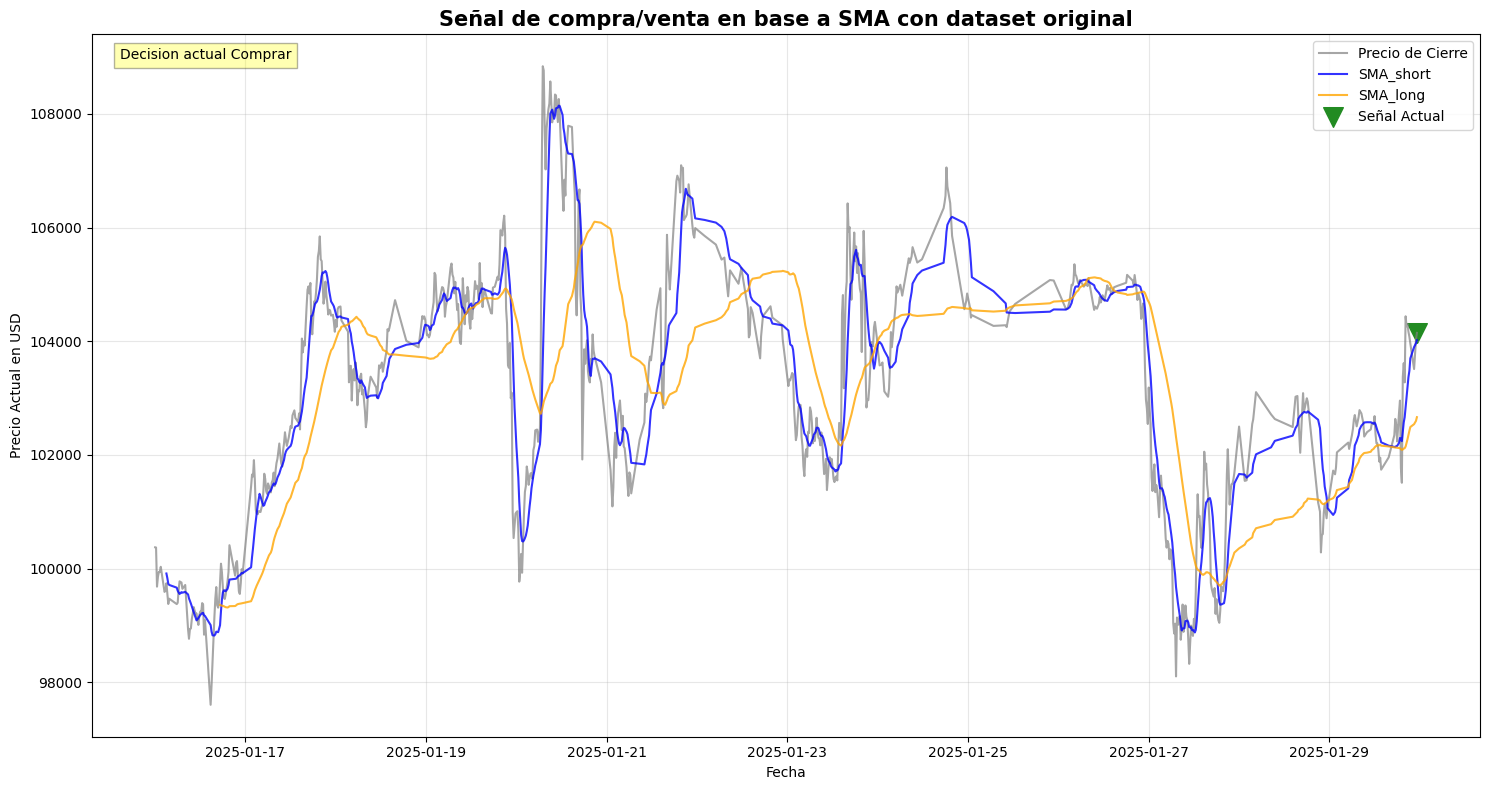

In [ ]:
visualizacion()

##6- Automatización

El trabajos esta terminado cuando la solución del problema esta automatizado, esto permite soluciones automaticas para los nuevos lotes de información.

Importaremos el metodo `clear_output()` y la libreria `time ` para construir un ciclo infinito que permita la ejecución permanente. en intervalos de 5 minutos, con las funciones que hicimos del paso 2 al 5.


[*********************100%***********************]  1 of 1 completed


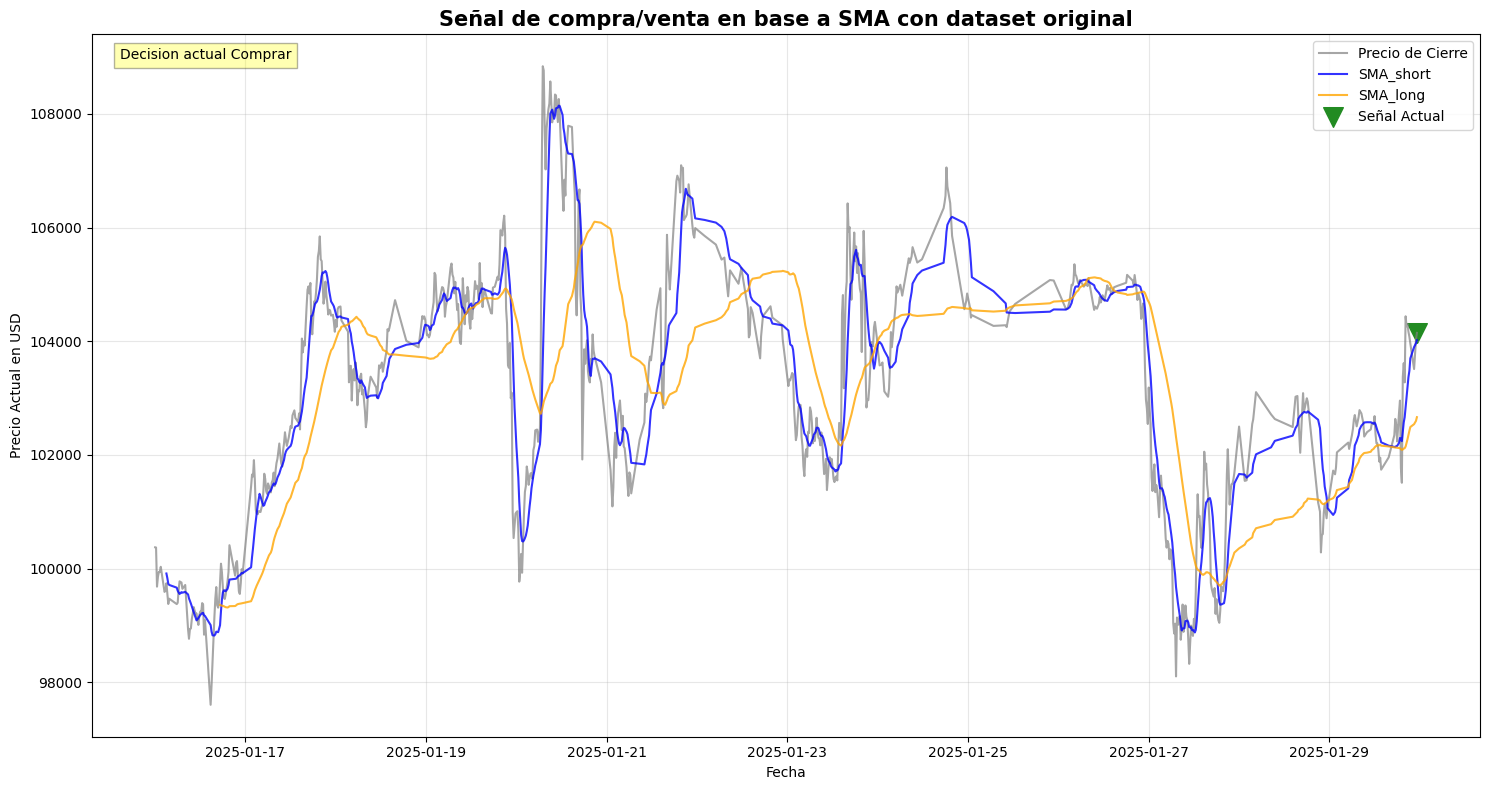

In [ ]:

#Con el método 'clear_output()', nosotros podemos limpiar los resultados en pantalla antes de mostrar
#un nuevo gréfico, y esto evitar tener mas de un gréfico en la pantalla, el método time.sleep(300) interrumpe
#la ejecución del codigo cada 300 segundos que son 5 minutos.
print('Comenzando Ciclo de analisis')
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)
